In [43]:
from KPrincipalGaussiansClassifier import KPrincipalGaussiansClassifier, MetaParams
import pandas as pd

variance_perc_threshold=0.98
model_name = f"mahalanobis_class-specific_{ variance_perc_threshold * 100 }"
print("model name: ", model_name)

def load_data(file_path): 
    print("loading data")
    all_data = pd.read_csv(file_path)
    train_data = all_data.to_numpy()[:, 1:]
    labels = all_data.to_numpy()[:, 0]
    print(f"train shape: {train_data.shape}")
    print(f"labels shape: {labels.shape}")
    
    return train_data, labels

class_components_weights = [
    1, # 0
    1, # 1
    1, # 2
    1, # 3
    1, # 4
    1, # 5
    1, # 6
    1, # 7
    1, # 8
    1, # 9
]
train_data_file_path = 'C:/src/data_analysis/data/digit-recognizer/train.csv'
train_data, labels = load_data(train_data_file_path)
meta_params = MetaParams(
    num_classes=10,
    class_components_weights=class_components_weights,
     n_init=1,
    tol=1e-4,
    variance_perc_threshold=variance_perc_threshold,
    k_near_centroids=5
) 

k_prin_gauss_model = KPrincipalGaussiansClassifier(meta_params=meta_params)
k_prin_gauss_model.fit(train_data=train_data, labels=labels)


model name:  mahalanobis_class-specific_98.0
loading data
train shape: (42000, 784)
labels shape: (42000,)
PCA k_seg_por_classe: 260
Treinando GaussianMixture para a classe: 0
K componentes ideal para classe 0: 203
Initialization 0
Initialization converged. time lapse 27.17577s	 lower bound -48629718.91658.
Treinando GaussianMixture para a classe: 1
K componentes ideal para classe 1: 127
Initialization 0
Initialization converged. time lapse 38.83127s	 lower bound -33214422.18141.
Treinando GaussianMixture para a classe: 2
K componentes ideal para classe 2: 234
Initialization 0
Initialization converged. time lapse 35.68350s	 lower bound -51242355.89888.
Treinando GaussianMixture para a classe: 3
K componentes ideal para classe 3: 224
Initialization 0
Initialization converged. time lapse 28.70031s	 lower bound -50881433.76403.
Treinando GaussianMixture para a classe: 4
K componentes ideal para classe 4: 220
Initialization 0
Initialization converged. time lapse 26.49668s	 lower bound -491

In [44]:
# Salvar modelo
'''
    Aqui salvamos o modelo para economizar tempo nas próximas execuções e armazenar os resultados.
'''
import numpy as np
np.save(model_name, [k_prin_gauss_model], allow_pickle=True)

print(k_prin_gauss_model.class_components_weights)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


loading data
train shape: (42000, 784)
labels shape: (42000,)


100%|███████████████████████████████████| 42000/42000 [00:10<00:00, 4076.91it/s]

Precisão: 0.9761904761904762


'\nPodemos usar a matriz de confusão para atribuir um peso diferente para cada classe no momento da inferência e comparação das medidas\nSabendo quanto de erro tivemos de uma classificação com relação à outra, podemos aumentar ou diminuir a importância das gaussianas\nde uma classe com relação à outra \n'

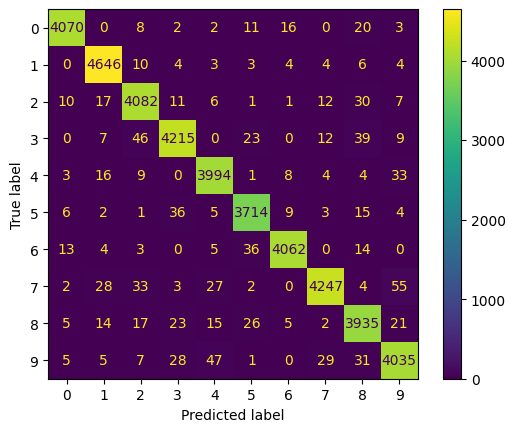

In [ ]:
# validar localmente
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

def load_data(file_path): 
    print("loading data")
    all_data = pd.read_csv(file_path)
    train_data = all_data.to_numpy()[:, 1:]
    labels = all_data.to_numpy()[:, 0]
    print(f"train shape: {train_data.shape}")
    print(f"labels shape: {labels.shape}")
    
    return train_data, labels

train_data_file_path = 'C:/src/data_analysis/data/digit-recognizer/train.csv'
train_data, labels = load_data(train_data_file_path)

loaded_arr = np.load(f'{model_name}.npy', allow_pickle=True)

kgmm = loaded_arr[0]
num_samples = 42000
validation_data = train_data[:num_samples,:]
labels_v = labels[:num_samples]
predictions = kgmm.predict(validation_data)
    
print("Precisão:", len(predictions[labels_v == predictions]) / num_samples)

# Compute confusion matrix
cm = confusion_matrix(labels_v, predictions)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

loading data
train shape: (42000, 784)
labels shape: (42000,)


k=1: 100%|██████████████████████████████| 42000/42000 [00:07<00:00, 5409.43it/s]


k=1 => pontos 95.73809523809523% representados


k=2: 100%|██████████████████████████████| 42000/42000 [00:07<00:00, 5512.16it/s]


k=2 => pontos 97.27380952380953% representados


k=3: 100%|██████████████████████████████| 42000/42000 [00:07<00:00, 5516.67it/s]


k=3 => pontos 97.90476190476191% representados


k=4: 100%|██████████████████████████████| 42000/42000 [00:07<00:00, 5520.28it/s]


k=4 => pontos 98.32619047619048% representados


k=5: 100%|██████████████████████████████| 42000/42000 [00:07<00:00, 5488.31it/s]


k=5 => pontos 98.57142857142858% representados


k=6: 100%|██████████████████████████████| 42000/42000 [00:07<00:00, 5500.13it/s]


k=6 => pontos 98.74047619047619% representados


k=7: 100%|██████████████████████████████| 42000/42000 [00:07<00:00, 5477.16it/s]


k=7 => pontos 98.86190476190477% representados


k=8: 100%|██████████████████████████████| 42000/42000 [00:07<00:00, 5482.74it/s]


k=8 => pontos 98.98095238095237% representados


k=9: 100%|██████████████████████████████| 42000/42000 [00:07<00:00, 5480.29it/s]


k=9 => pontos 99.06904761904762% representados


k=10: 100%|█████████████████████████████| 42000/42000 [00:07<00:00, 5450.55it/s]


k=10 => pontos 99.14761904761905% representados


k=11: 100%|█████████████████████████████| 42000/42000 [00:07<00:00, 5465.17it/s]


k=11 => pontos 99.22380952380952% representados


k=12: 100%|█████████████████████████████| 42000/42000 [00:07<00:00, 5354.28it/s]


k=12 => pontos 99.2904761904762% representados


k=13: 100%|█████████████████████████████| 42000/42000 [00:07<00:00, 5358.38it/s]


k=13 => pontos 99.32857142857144% representados


k=14: 100%|█████████████████████████████| 42000/42000 [00:07<00:00, 5357.12it/s]


k=14 => pontos 99.36428571428571% representados


k=15: 100%|█████████████████████████████| 42000/42000 [00:07<00:00, 5422.41it/s]

k=15 => pontos 99.39523809523808% representados


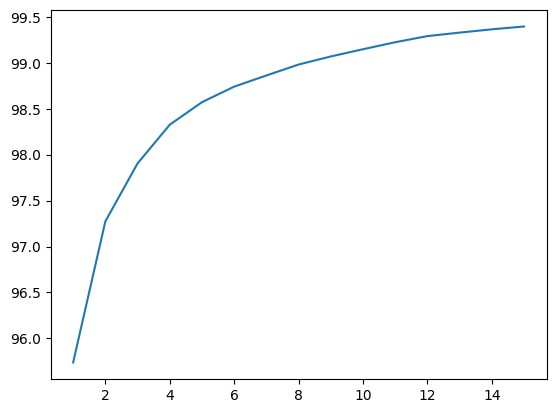

In [41]:
''' 
  97.6 % de acerto nos dados de treino já é uma boa marca, mas esse valor pode melhorar.
  O grande problema é que as porcentagens de erro ocorrem quando há uma relação discreta e não linear que o nosso modelo não coneseguiu aprender.
  Aumentar o número de segmentos irá aumentar o tempo de treinamento e gerar overfitting.
  Para representar adequadamente essas relações não lineares entre as classes e permitir que nosso modelo tenha uma taxa maior de acerto, 
  ao invés de usarmos a menor distância de mahalanobis para determinar a resposta da classificação, iremos criar uma rede neural para 
  apreender estes relacionamentos. 
  
  Para conseguirmos fazer isso de forma eficiente no nosso contexto, buscaremos passar o mínimo de informações possíveis para a rede neural.
  Desta forma, o metaparâmetro mais relevante é o número de segmentos próximos retornados pela busca usando a distância euclidiana como método.
  precisamos saber qual é o k mínimo que encontra em todos os casos a gaussiana da classe correta, 
  ainda que ela possua uma distância de mahalanobis maior do que a classe que o modelo respondeu.
  
  Nesta célula encontraremos o número de k_segmentos_proximos a partir de um modelo de gaussianas pré treinado.
'''

# validar localmente
import numpy as np
import pandas as pd
from tqdm import tqdm
from search_optimization import find_closest_segments
import matplotlib.pyplot as plt
 
def load_data(file_path): 
    print("loading data")
    all_data = pd.read_csv(file_path)
    train_data = all_data.to_numpy()[:, 1:]
    labels = all_data.to_numpy()[:, 0]
    print(f"train shape: {train_data.shape}")
    print(f"labels shape: {labels.shape}")
    
    return train_data, labels

train_data_file_path = 'C:/src/data_analysis/data/digit-recognizer/train.csv'
train_data, labels = load_data(train_data_file_path)
loaded_arr = np.load(f'{model_name}.npy', allow_pickle=True)

kgmm = loaded_arr[0]
num_samples = 42000
labels_v = labels[:num_samples]
validation_data = train_data[:num_samples,:]

meta_arams = kgmm.meta_params
search_index = kgmm.hnsw
porcentagens_representacao = []
transformed_points = kgmm.pca.transform(validation_data)

for k in range(1, 16):
  meta_params.k_near_centroids = k
  pontos_representados = 0
  for idx in tqdm(range(len(train_data)), desc=f"k={k}",ncols=80, colour="blue"): 
    p = transformed_points[idx]
    label = labels_v[idx]
    indices = find_closest_segments(hnsw=search_index, point=p, metaparams=meta_params)
    classes = (indices // (kgmm.k_segments_per_class)).astype(int) 
    if (np.isin(label, classes)):
      pontos_representados += 1
  porcentagem = pontos_representados/num_samples * 100
  porcentagens_representacao.append(porcentagem)
  print(f"k={k} => pontos {porcentagem}% representados")
  if (porcentagem == 100):
    break;

plt.plot(np.arange(1,16,1), porcentagens_representacao)

In [ ]:
''' 
  97.6 % de acerto nos dados de treino já é uma boa marca, mas esse valor pode melhorar.
  O grande problema é que as porcentagens de erro ocorrem quando há uma relação discreta e não linear que o nosso modelo não coneseguiu aprender.
  Aumentar o número de segmentos irá aumentar o tempo de treinamento e gerar overfitting.
  Para representar adequadamente essas relações não lineares entre as classes e permitir que nosso modelo tenha uma taxa maior de acerto, 
  ao invés de usarmos a menor distância de mahalanobis para determinar a resposta da classificação, iremos criar uma rede neural para 
  apreender estes relacionamentos. 
  
  Para conseguirmos fazer isso de forma eficiente no nosso contexto, buscaremos passar o mínimo de informações possíveis para a rede neural.
  Desta forma, o metaparâmetro mais relevante é o número de segmentos próximos retornados pela busca usando a distância euclidiana como método.
  precisamos saber qual é o k mínimo que encontra em todos os casos a gaussiana da classe correta, 
  ainda que ela possua uma distância de mahalanobis maior do que a classe que o modelo respondeu.
  
  Nesta célula encontraremos o número de k_segmentos_proximos a partir de um modelo de gaussianas pré treinado.
'''

# validar localmente
import numpy as np
import pandas as pd
from tqdm import tqdm
from search_optimization import find_closest_segments
import matplotlib.pyplot as plt
 
def load_data(file_path): 
    print("loading data")
    all_data = pd.read_csv(file_path)
    train_data = all_data.to_numpy()[:, 1:]
    labels = all_data.to_numpy()[:, 0]
    print(f"train shape: {train_data.shape}")
    print(f"labels shape: {labels.shape}")
    
    return train_data, labels

train_data_file_path = 'C:/src/data_analysis/data/digit-recognizer/train.csv'
train_data, labels = load_data(train_data_file_path)
loaded_arr = np.load(f'{model_name}.npy', allow_pickle=True)

kgmm = loaded_arr[0]
num_samples = 42000
labels_v = labels[:num_samples]

meta_arams = kgmm.meta_params
search_index = kgmm.hnsw
porcentagens_representacao = []
validation_data = train_data[:num_samples,:]

for k in range(1, 16):
  meta_params.k_near_centroids = k
  pontos_representados = 0
  for idx in tqdm(range(len(train_data)), desc=f"k={k}",ncols=80, colour="blue"): 
    p = validation_data[idx]
    label = labels_v[idx]
    indices = find_closest_segments(hnsw=search_index, point=p, metaparams=meta_params)
    classes = (indices // (kgmm.k_segments_per_class)).astype(int) 
    if (np.isin(label, classes)):
      pontos_representados += 1
  porcentagem = pontos_representados/num_samples * 100
  porcentagens_representacao.append(porcentagem)
  print(f"k={k} => pontos {porcentagem}% representados")
  if (porcentagem == 100):
    break;

plt.plot(np.arange(1,16,1), porcentagens_representacao)

loading data
train shape: (42000, 784)
labels shape: (42000,)


k=10: 100%|█████████████████████████████| 42000/42000 [00:08<00:00, 4868.43it/s]


k=10 => pontos 58.273809523809526% representados


k=11: 100%|█████████████████████████████| 42000/42000 [00:08<00:00, 4849.09it/s]


k=11 => pontos 58.490476190476194% representados


k=12: 100%|█████████████████████████████| 42000/42000 [00:08<00:00, 4889.67it/s]


k=12 => pontos 58.590476190476195% representados


k=13: 100%|█████████████████████████████| 42000/42000 [00:08<00:00, 4944.30it/s]


k=13 => pontos 58.666666666666664% representados


k=14:  96%|███████████████████████████▋ | 40144/42000 [00:08<00:00, 4753.61it/s]


KeyboardInterrupt: 

In [14]:
''' Gerar submissão '''
loaded_arr = np.load(f'{model_name}.npy', allow_pickle=True)

kgm = loaded_arr[0]  
file_path = '../data/digit-recognizer/test.csv' 
test_data = pd.read_csv(file_path)
data_points = test_data.to_numpy()
 
test_data.loc[:, "Label"] = kgm.predict(data_points).astype(int)
answer = test_data[["Label"]].copy() 
answer["ImageId"] = range(1, len(answer) + 1)  
answer = answer[["ImageId", "Label"]]

# Save to CSV
output_file = f"{model_name}.csv"
answer.to_csv(output_file, index=False)

100%|███████████████████████████████████| 28000/28000 [00:09<00:00, 2905.72it/s]
